<center>
    <img src="https://github.com/GuitarsAI/MRSP_Notebooks/blob/master/images/msp_header.png?raw=1">
</center>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta

# Optimization of Filter Banks

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/5TdrxOhlROk?rel=0" frameborder="0" allow="accelerometer; aencrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

## Goal

Obtain a filter bank from our structure or product $H(z)=F_a⋅D(z)\cdot G(z)$ .... , which has "good" subband filters, i.e. a good or sufficient stopband attenuation and not much pass band attenuation. An example could be a desired stopband attenuation of -60dB and a pass band attenuation of less than -3dB.

## Problem to solve:

The coefficients which determine the frequency responses are the coefficients in our cascade or product, the coefficients in our matrices $e_j^i , h , g_j^i  \dots$

They result in the frequency response in a nonlinear way, hence the usual filter design approaches don't work here, previous approaches like the Remez-exchange algorithm.

Those traditional filter design algorithms can also be seen as optimization algorithms for more or less linear problems (or quadratic if we take the mean squared error).

We can read out the resulting analysis baseband prototype impulse response $h_a(n)$ for instance by computing the sparse folding matrix the product:

$$\large
H(z) = F_a \cdot D(z) \cdot \prod_{n=0}^{P-1} G_n(z) \cdot \prod_{m=0}^{Q-1} H_m(z)$$

(without the transform matrix T ), and then compare it with eq. (1) of Lesson 14,

$$\large
F_a(z) = \\
\large
\left[ 
    \begin{array}{cccccc} 
    . & 0 & -H_{2N-1}^{\downarrow 2N}\left(-z^2\right)\cdot z^{-1} & 
    -H_{N-1}^{\downarrow 2N}\left(-z^2\right)\cdot z^{-1} & 0 & . \\ 
    . & . & 0 & 0 & . & . \\
    -H_{1.5N}^{\downarrow 2N}\left(-z^2\right)\cdot z^{-1} & 0 & . & 
    . & 0 & -H_{\frac{N}{2}}^{\downarrow 2N}\left(-z^2\right) \\
    -H_{1.5N-1}^{\downarrow 2N}\left(-z^2\right)\cdot z^{-1} & 0 & . & 
    . & 0 & H_{\frac{N}{2}-1}^{\downarrow 2N}\left(-z^2\right) \\
    0 & . & 0 & . & . & 0 \\
    . & 0 & -H_{N}^{\downarrow 2N}\left(-z^2\right)\cdot z^{-1} & 
    H_{0}^{\downarrow 2N}\left(-z^2\right) & 0 & . \\
    \end{array}
\right]
$$

with

$$\large
H_{n}^{\downarrow 2N}(z) := \sum_{m=0}^{\infty}h_a(m2N+n)\cdot z^{-m}
$$

In this way we obtain ha(n) , and hence its frequency response, from our matrix coefficients
$x=[h1, h2, ... , e_j^i ,... ,h_j^i , ...]$. We can do the same for the synthesis side, or we restrict the (sub-) matrices to have det(.)=-1, in which case the synthesis baseband impulse response is the same as for the analysis.

Another possibility to obtain the analysis baseband impulse response is to compute the polyphase matrix $H(z)$. Its first column contains the **polyphase elements of the first subband filter in reverse order.** This can be used to read out its impulse response $h_0(n)$. To obtain $h_a(n)$ we simply divide $h_0(n)$ by the modulation function for the first subband (for k=0).

## Our approach:

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/1CPRvSBddE4?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

Since we now have this non-linear dependency of our baseband impulse response from the matrix coefficients, we need to use “more powerful” optimization algorithms, which are made for just mostly convex error functions.

We first define an **error function**, and then we use an **optimization** algorithm to minimize this error function. This error function can be the sum of the magnitudes, or the squares, of the **differences between our obtained frequency response**, given our unknown variables at some point, **and our desired frequency response.** 

To give the stop band attenuation and the pass band ripples different weights, we can also **assign weights to the different frequency regions** for our error function.

So our starting point is a vector of all of our unknowns of our matrices, $x=[h1, h2, ... , e_j^i ,... ,h_j^i , ...]=[x_1,x_2]$. We now define a function which computes the baseband impulse response out of these unknowns, by multiplying our matrices to obtain our final folding matrix or the polyphase matrix, and then read out the baseband impulse response.

This then yields the baseband prototype for our coefficient set x , which we call $h_x(n)$ This is now used to compute a **weighted frequency response, at k frequency points**, with weights $w_i$ for each frequency point:

$$\large
H_i= \sum_{n=0}^{L\cdot N-1} h_x(n)\cdot e^{j\omega_i\cdot n)} \cdot w_i, \text{for i = 0,...,k-1}$$
<cite>(see also Schuller, Smith: “New Framework for Modulated Perfect Reconstruction Filter Banks”, IEEE Transactions on Signal Processing, August 1996)</cite>

For instance we can use "freqz" to compute $H_i$ (by default it computes 512 equally spaced frequency points), and then multiply it with the weights $w_i$.

We choose as many frequency points as necessary to sufficiently cover our frequency response. Usually it should be **several times the length of our filter**, to avoid sampling the frequency response accidentally near its zeros. The more important frequency points in terms of attenuation get the higher weights.

The same can also be done for the synthesis, but remember that this is only necessary if we don't have det(..)=-1, because for det(..)=-1, we obtain identical prototype impulse responses for analysis and synthesis, and we only need to optimize the analysis (Lecture 13 and 14).

We also need to have a vector containing the weighted desired frequency response, which would be 1 for the pass band (multiplied by the corresponding weights), and zeros in the stop band. We call this **d **(for desired).

Our error function of our vector of unknowns *x* is now:

$$\large
f(x) = \sum_{i=1}^{2k} \mid H_i(x)-d_i \mid^2=(\mathbf{H-d})\overline{(\mathbf{H-d})^T} $$

(row times column vector). Now we just need to minimize this function f(x) with respect to our vector of unknows *x*.

This leads us to optimization in general. The goal of optimization is to find the vector *x* which minimizes the error function f(x).


In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/rn_7bq3BGRQ?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

We know: in a minimum, the functions derivative is zero:
$$\large
f'(x):=\frac{df(x)}{dx}=0$$

An approach to iteratively find the zero of a function is **Newtons method.** Take some function f(x), where x is not a vector but just a number, then we can find its zero as depicted in the following picture:

<center>
    <img src="https://github.com/GuitarsAI/MRSP_Notebooks/blob/master/images/Lecture15_01_newtons.png?raw=1" width="600"/>
    <small> from https://tutorial.math.lamar.edu/classes/calci/newtonsmethod.asp </small>
</center>
              
with the iteration:
$$\large
x_{k+1}=x_k-\dfrac{f(x_k)}{f'(x_k)}, \text{k=0,1,2...}$$

Observe: Sometimes we need to compute the derivative numerically, by evaluating the function a few times in the neighborhood, and eg. compute $\dfrac{\Delta f}{\Delta x}$ , for a small $\Delta x$ (there more involved methods for it).

Now we want to find the zero not of f(x) , but of f'(x) , hence we simply replace f(x) by f'(x) and obtain the following iteration,
$$\large
x_{k+1}=x_k-\dfrac{f'(x_k)}{f''(x_k)}$$

To obtain a minimum (not a maximum) we need the condition $f''(x_k)>0$

## Example for finding a zero of a function:

Compute $\sqrt{2}$ numerically by finding the zero of the function $f(x)=x^2-2$.

We know the solution is $\sqrt{2}$ . Now apply Newtons Method to find this solution numerically. The first derivative is $f'(x)=2x$.

The Newton iteration is 

$$\large
x_{k+1}=x_k-\dfrac{f(x_k)}{f'(x_k)}=x_k - \dfrac{x_k^2-2}{2x_k}$$

In ipython and with a starting value of 1 this becomes:

In [ ]:
x=1.0
for i in range(3):
    x=x-(x**2-2)/(2*x)
    print(x)

1.5
1.4166666666666667
1.4142156862745099


(True value: 1.4142135623730951)

We see: after only 3 iterations we obtain $\sqrt{2}$ with 6 digits accuracy!

### Example

Find the minimum of cos(x) . We know a minimum is at $x=\pi$ , so this is also a way to numerically determine $\pi$.
We have:
$$\large
f(x)=cos(x) \\
\large
f'(x)=-sin(x) \\
\large
f''(x)=-cos(x)
$$

Newton update:
$$\large
x_{new}=x_{old}-\dfrac{f'(x_{old})}{f''(x_{old})}=x_{old}-\dfrac{sin(x_{old})}{cos(x_{old})}$$

In ipyhton we simply repeatedly use the expression:
`x=x-sin(x)/cos(x)`

We start with x=3 and preoceed with the Newton update:

In [ ]:
import math as m
x=100
for i in range(3):
    x=x-m.sin(x)/m.cos(x)
    print(x)


100.58721391515692
100.53090551669032
100.53096491487345


We see that this iteration indeed converges to $\pi$ ! It computes $\pi$ =3.141592653589793 with an accuracy of 10 digits after only 2 iterations!

Observe: if you start with x=1, it converges to 0, which is a **maximum** of our function, which also has the first derivative as zero! This shows that we still need to check the second derivative, to see if it is a minimum or a maximum. 

If we start with x=100, it converges to $32\pi$, which is a minimum, but perhaps not the expected minimum. This shows that **starting point is important**!

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/CPI1-OJo5z8?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

For a **multi-dimensional** function, where the argument *x* is a vector, the first derivative is a vector called "Gradient", with symbol Nabla $\nabla$ , because we need the derivative with respect to each element of the argument vector *x*:

$$\large
\nabla f(x)=
\left(
\begin{array}{c}
\dfrac{\partial f}{\partial x_1} \\
\vdots \\
\dfrac{\partial f}{\partial x_n} \\
\end{array}
\right)
$$

(where n is the number of unknowns in the argument vector **x**). For the **second derivative** we need to take each element of the gradient vector and again take the derivative to each element of the argument vector. Hence we obtain a matrix, the **Hesse Matrix**, as matrix of second derivatives:

$$\large
H_f(x)=
\left(
\begin{array}{ccc}
    \dfrac{\partial^2 f}{\partial x_1 \partial x_1} & \dots & \dfrac{\partial^2 f}{\partial x_1 \partial x_n} \\
    \vdots & \ddots & \vdots \\
    \dfrac{\partial^2 f}{\partial x_n \partial x_1} & \dots & \dfrac{\partial^2 f}{\partial x_n \partial x_n} \\
\end{array}
\right)
$$

Observe that this Hesse Matrix is symmetric (for "reasonable" function we consider, like continuous functions). Using these definitions we can generalize our Newton algorithm to the multi-dimensional case. The one-dimensional iteration:


$$\large
x_{k+1}=x_k-\dfrac{f'(x_k)}{f''(x_k)}$$

turns into the multi-dimensional iteration:

$$\large
x_{k+1}=x_k-H_f^{-1}(x_k)\nabla f(x_k)$$

For a minimum, $H_f(x)$ must be positive definite (all eigenvalues are positive).

The problem here is that for the Hesse matrix we need to compute $n^2$ second derivatives, which can be computationally too complex, and then we need to invert this matrix. Hence we now make the simplifying assumption, that the Hesse matrix can be written as a **diagonal matrix with constant values on the diagonal.**

Observe that this is mostly a very crude approximation, but since we have an iteration with many small updates it can still work:

$$\large
H_f(x_k)=\dfrac{1}{\alpha}\cdot \mathbf{I}
$$

The best value of $\alpha$ depends on how good it approximates the Hesse matrix.

Hence our iteration $x_{k+1}=x_k-H_f^{-1}(x_k)\nabla f(x_k)$ turns into:

$$\large
\begin{equation}
x_{k+1}=x_k-\alpha \cdot \nabla f(x_k)
\end{equation}
$$

which is much simpler to compute. This is also called **"Steepest Descent"**, because the gradient tell us the direction of the steepest descent, or **"Gradient Descent"**.

We see that the update of *x* consists only of the gradient $\nabla f(x_k)$ scaled by the factor $\alpha$. In each step, we reduce the value of f(x) by moving *x* in the direction of the gradient. If we make $\alpha$ larger, we obtain larger update steps and hence quicker convergence to the minimum, but it may oscillate around the minimum. For smaller $\alpha$ the steps become smaller, but it will converge more precisely to the minimum.

Because of the update direction along the gradient, this method is also called **"Gradient Descent"**.

### Example

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/-6HBvDv4l50?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

Find the 2-dimensional minimum of the function:
$$\large
f(x_1,x_2)=cos(x_1)-sin(x_2)
$$

Its gradient is:
$$\large
\nabla f(x_1,x_2)=[-sin(x_1), -cos(x_2)]
$$

In ipython we choose $\alpha=1$ and a starting point of $[x1, x2]=[2,2]$:


In [ ]:
import numpy as np
alpha=1;
#start:
x=np.array([2,2])
for i in range(3):
    x= x -alpha*np.array([-m.sin(x[0]), -m.cos(x[1])])
    print(x)

[2.90929743 1.58385316]
[3.13950913 1.5707967 ]
[3.14159265 1.57079633]


We see: the minimum is obtained for $x_1=3.14159265$ (exact value: $\pi =3.141592653589793$) and $x_2=1.57079633$ (exact value: $\dfrac{π}{2} =1.5707963267948966$).

**Observe** that we needed **3 iterations** to obtain 9 digit accuracy in this 2-dimensional case. In the 1-dimensional case with the **Newton** iteration we needed only **2 iterations** for the same accuracy.

## Python Example for the Optimization of an MDCT Filter Bank

The function "optimfuncMDCT" contains an optimization of the baseband prototype, with det(..)=-1, for a given number of subbands, set in the main part of the program, for instance N=8.

In [ ]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/6eV8svWxaZg?rel=0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [ ]:
# Imports
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.signal as sig
import matplotlib.pyplot as plt

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 04 16:59:32 2016
@author: Max
after Matlab function by Gerald Schuller
Modified July 2016, Gerald Schuller
"""

import numpy as np

def polmatmult( A,B ):
    """polmatmult(A,B)
    multiplies two polynomial matrices (arrays) A and B, where each matrix entry is a polynomial.
    Those polynomial entries are in the 3rd dimension
    The thirs dimension can also be interpreted as containing the (2D) coefficient
    exponent of z^-1.
    Result is C=A*B;"""
    
    [NAx, NAy, NAz] = np.shape(A);
    [NBx, NBy, NBz] = np.shape(B);
    "Degree +1 of resulting polynomial, with NAz-1 and NBz-1 being the degree of the..."
    Deg = NAz + NBz -1;
    #initialize (with complex zeros):
    C = np.zeros((NAx,NBy,Deg))#*(1+1j);
    "Convolution of matrices:"
    for n in range(0,(Deg)):
        for m in range(0,n+1):
            if ((n-m)<NAz and m<NBz):
                C[:,:,n] = C[:,:,n]+ np.dot(A[:,:,(n-m)],B[:,:,m]);
    return C
   

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 04 17:34:26 2016
from Matlab
@author: Max, Gerald Schuller
"""

import numpy as np
def Dmatrix(N):
    """produces a delay matrix D(z), which has delay z^-1 on the upper half of its diagonal
    in a 3D polynomial representation (exponents of z^-1 are in the third dimension) 
    N is number of subbands and size of the polynomial matrix (NxN) 
    N is even""" 
    D=np.zeros((N,N,2));    
    D[:,:,0] = np.diag(np.append(np.zeros((1,int(N/2))), np.ones((1,int(N/2)))));
    D[:,:,1] = np.diag(np.append(np.ones((1,int(N/2))), np.zeros((1,int(N/2)))));  
    return D;


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 04 18:29:15 2016 from Matlab, author: Max, 
Gerald Schuller, Sep. 2017
"""
from __future__ import print_function  
import numpy as np
def symFmatrix(f):
    """produces a diamond shaped folding matrix F from the coefficients f
    (f is a 1-d array)
    which leads to identical analysis and synthesis baseband impulse responses
    Hence has det 1 or -1
    If N is number of subbands, then f is a vector of size 1.5*N coefficients.
    N is even
    returns: F of shape (N,N,1)
    """   
    sym=1.0; #The kind of symmetry: +-1
    N = int(len(f)/1.5);
    F=np.zeros((N,N,1))
    F[0:int(N/2),0:int(N/2),0]=np.fliplr(np.diag(f[0:int(N/2)]))
    F[int(N/2):N,0:int(N/2),0]=np.diag(f[int(N/2):N])
    F[0:int(N/2),int(N/2):N,0]=np.diag(f[N:(N+int(N/2))])
    ff = np.flipud((sym*np.ones((int(N/2))) - (f[N:(int(1.5*N))])*f[N-1:int(N/2)-1:-1])/f[0:int(N/2)])     
    F[int(N/2):N,int(N/2):N,0]=-np.fliplr(np.diag(ff))
    return F
   


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 04 17:59:00 2016
from Matlab
@author: Tobias Heinl, Gerald Schuller

Function extracts analysis baseband impulse response (reverse window function) 
from the folding matrix Fa of a cosine 
modulated filter bank, with modulation function for the analysis IR : 
h_k(n)=h(n)*cos(pi/N*(k+0.5)*(L-1-n+0.5-N/2));

""" 
def Fa2h(Fa):
    """ Function extracts analysis baseband impulse response (reverse window function) 
    from the folding matrix Fa of a cosine modulated filter bank.
    """
    import numpy as np
    [N,y,blocks] = np.shape(Fa) 
    h0 = np.zeros(blocks * N)
    #First column of DCT-4:
    T = np.zeros((N,1,1)) 
    T[:,0,0]=np.cos(np.pi/N*(0.5)*(np.arange(N)+0.5))
    #Compute first column of Polyphase matrix Pa(z):
    Pa =  polmatmult(Fa,T)
    #Extract impulse response h0(n):
    for m in range(blocks): 
        h0[m*N+np.arange(N)] = np.flipud(Pa[:,0,m]) 
    #Baseband prototype h(n), divide by modulation func.:
    #h = h0 / np.cos(np.pi/N*0.5*(np.arange(blocks*N)+ 0.5+(N/2)))
    h = -h0 / np.cos(np.pi/N*0.5*(np.arange(blocks*N-1,-1,-1)+ 0.5-(N/2)))
    return h;  

Starting x0 [-0.13077921 -0.76606932 -0.53120745 -0.35528202 -0.33121792 -0.28339573]
h [6.74667051 1.10885276 0.28339573 0.33121792 0.35528202 0.53120745
 0.76606932 0.13077921]
pb 128
128


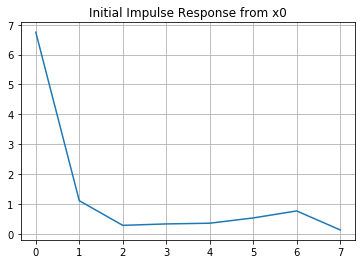

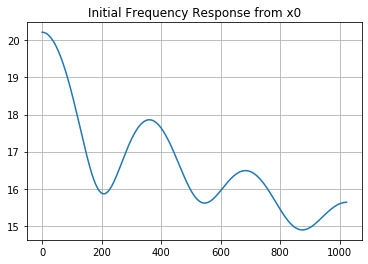

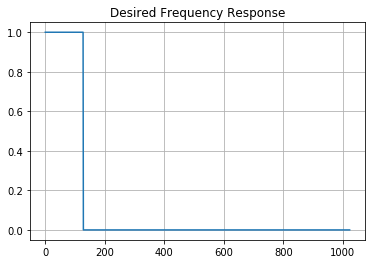

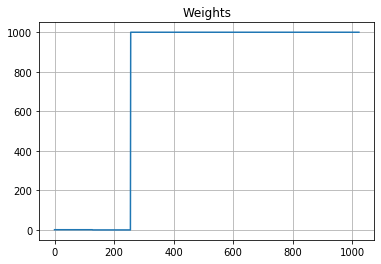

In [ ]:
N=4
x0 = -np.random.rand(int(1.5*N))
print('Starting x0',x0)
Fa = symFmatrix(x0)
D = Dmatrix(N)
Faz = polmatmult(Fa,D)
h = Fa2h(Faz)
print('h',h)

plt.figure()
plt.plot(h)
plt.title('Initial Impulse Response from x0')
plt.grid()
w, H = sig.freqz(h,1,1024)
pb = int(1024/N/2)
print('pb',pb)

plt.figure()
plt.plot(20*np.log10(np.abs(H)))
plt.title('Initial Frequency Response from x0')
plt.grid()
Hdes = np.concatenate((np.ones((pb,1)) , np.zeros(((1024-pb, 1)))), axis = 0)

plt.figure()
plt.plot(Hdes)
plt.title('Desired Frequency Response')
plt.grid()
tb = np.round(pb)
print(tb)
weights = np.concatenate((np.ones((pb,1)) , np.zeros((tb, 1)), 1000*np.ones((1024-pb-tb,1))), axis = 0)

plt.figure()
plt.plot(weights)
plt.title('Weights')
plt.grid()

In [ ]:
"""
Created on Thu Feb 04 19:33:24 2016
from Matlab
@author: Tobias Heinl, Gerald Schuller


function for optimizing an MDCT type filter bank. 
x: unknown matirx coefficients, x: 1-d vector! 

"""

def optimfuncMDCT(x, N):
    """Computes the error function for the filter bank optimization
    for coefficients x, a 1-d array, N: Number of subbands""" 
    import numpy as np
    import scipy.signal as sig
   
    #x = np.transpose(x) 
    Fa = symFmatrix(x)
    D = Dmatrix(N)
    Faz = polmatmult(Fa,D)
    h = Fa2h(Faz)
    h = np.hstack(h)
    w, H = sig.freqz(h,1,1024)
    pb = int(1024/N/2)
    Hdes = np.concatenate((np.ones((pb,1)) , np.zeros(((1024-pb, 1)))), axis = 0)
    tb = np.round(pb)
    weights = np.concatenate((np.ones((pb,1)) , np.zeros((tb, 1)), 1000*np.ones((1024-pb-tb,1))), axis = 0) 
    err = np.sum(np.abs(H-Hdes)*weights)
    return err  

starting error= 4797122905.016674
         Current function value: 1043146993.298535
         Iterations: 68
         Function evaluations: 2714
         Gradient evaluations: 193
optimized coefficients= [-0.12898962 -0.28614769 -0.45889834 -0.62918827 -0.77726352 -0.88849878
 -0.95819286 -0.99164919 -0.99164294 -0.95818137 -0.88848579 -0.77725265]
error after optim.= 1043146993.298535
h= [0.12898773 0.28613705 0.45888476 0.62917554 0.77725265 0.88848579
 0.95818137 0.99164294 0.99164919 0.95819286 0.88849878 0.77726352
 0.62918827 0.45889834 0.28614769 0.12898962]
Wall time: 57.3 s


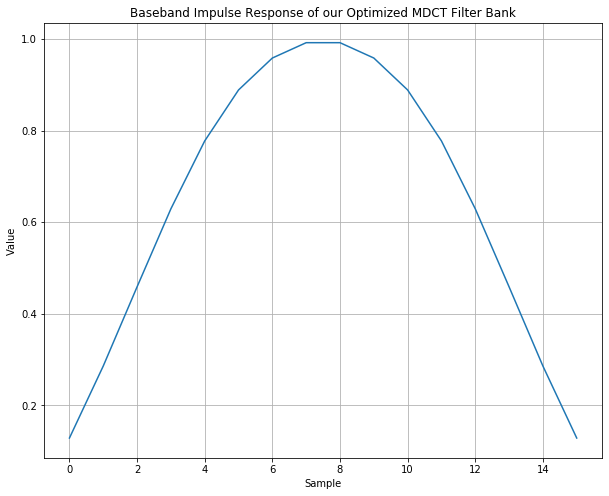

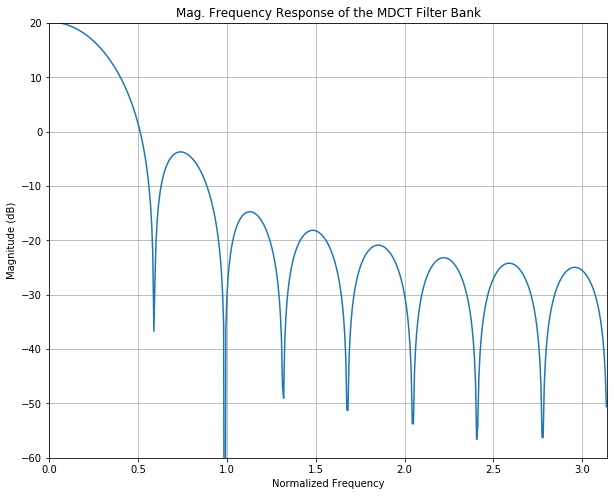

In [ ]:
%%time
N=8
#Start optimization with some starting point:
x0 = -np.random.rand(int(1.5*N))
print("starting error=", optimfuncMDCT(x0, N)) #test optim. function
xmin = sp.optimize.minimize(optimfuncMDCT, x0, args=(N,), options={'disp':True})
print("optimized coefficients=", xmin.x)
np.savetxt("MDCTcoeff.txt", xmin.x)
print("error after optim.=", optimfuncMDCT(xmin.x, N))
#Baseband Impulse Response:
Fa = symFmatrix(xmin.x) 
Faz = polmatmult(Fa, Dmatrix(N))
h = Fa2h(Faz)
print("h=", h)
plt.figure(figsize=(10,8))
plt.plot(h)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Baseband Impulse Response of our Optimized MDCT Filter Bank')
plt.grid()
plt.figure(figsize=(10,8))
#Magnitude Response:
w,H=sp.signal.freqz(h) 
plt.plot(w,20*np.log10(abs(H)))
plt.axis([0, 3.14, -60,20])
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.title('Mag. Frequency Response of the MDCT Filter Bank') 
plt.grid()

It starts with random coefficients, and prints their resulting error value. Then it optimizes the coefficients using "scipy.optimize.minimize" (it needs scipy version 0.19.1 or later), and after finishing the optimization prints out the resultingn error value, and plots the resulting baseband prototype and its magnitude frequency response.

For N=4 it is fairly fast. Observe that N=8 subbands already takes some time, N=16 takes a lot longer.

Observe that the resulting baseband impulse response is similar to the sine window, but not exactly the same, it is “more optimal” in our optimization functions sense.

starting error= 8071027923.306213
         Current function value: 1142039152.954523
         Iterations: 109
         Function evaluations: 5679
         Gradient evaluations: 218
optimized coefficients= [-0.06486723 -0.13868403 -0.22025102 -0.30746628 -0.39868818 -0.49094693
 -0.58153766 -0.66713626 -0.74496602 -0.81354839 -0.8712176  -0.91711006
 -0.95157698 -0.97545976 -0.99034679 -0.99789746 -0.99789064 -0.99032938
 -0.97543203 -0.95155    -0.91707795 -0.87118318 -0.81351954 -0.74493936]
error after optim.= 1142039152.9545228
h= [0.06486271 0.13866398 0.22022739 0.30743836 0.39865387 0.4909082
 0.58149714 0.66709833 0.74493936 0.81351954 0.87118318 0.91707795
 0.95155    0.97543203 0.99032938 0.99789064 0.99789746 0.99034679
 0.97545976 0.95157698 0.91711006 0.8712176  0.81354839 0.74496602
 0.66713626 0.58153766 0.49094693 0.39868818 0.30746628 0.22025102
 0.13868403 0.06486723]
Wall time: 1min 57s


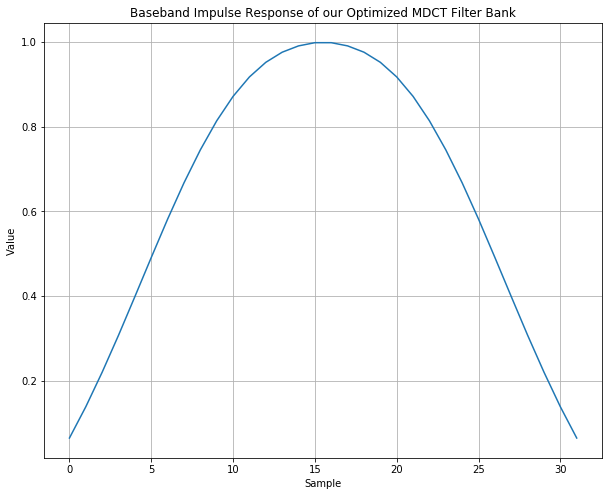

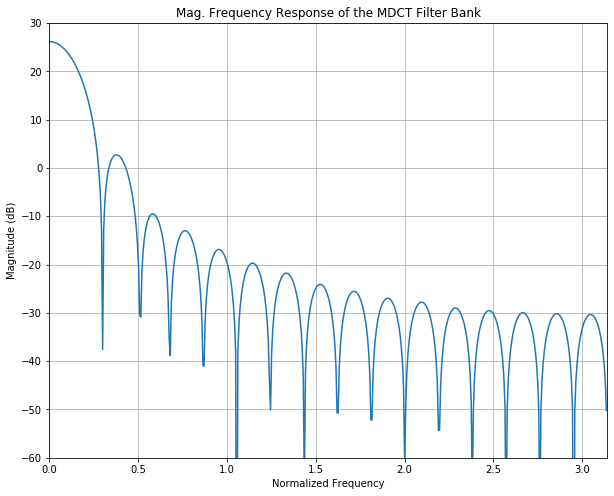

In [ ]:
%%time
N=16
#Start optimization with some starting point:
x0 = -np.random.rand(int(1.5*N))
print("starting error=", optimfuncMDCT(x0, N)) #test optim. function
xmin = sp.optimize.minimize(optimfuncMDCT, x0, args=(N,), options={'disp':True})
print("optimized coefficients=", xmin.x)
np.savetxt("MDCTcoeff.txt", xmin.x)
print("error after optim.=", optimfuncMDCT(xmin.x, N))
#Baseband Impulse Response:
Fa = symFmatrix(xmin.x) 
Faz = polmatmult(Fa, Dmatrix(N))
h = Fa2h(Faz)
print("h=", h)
plt.figure(figsize=(10,8))
plt.plot(h)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Baseband Impulse Response of our Optimized MDCT Filter Bank')
plt.grid()
plt.figure(figsize=(10,8))
#Magnitude Response:
w,H=sp.signal.freqz(h) 
plt.plot(w,20*np.log10(abs(H)))
plt.axis([0, 3.14, -60,30])
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.title('Mag. Frequency Response of the MDCT Filter Bank') 
plt.grid()